![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

## 1. Librerias & Google Drive

Para empezar carguemos esas librerias que nos hacen falta

In [1]:
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import time
import datetime
import os.path
import random
import math

In [2]:
# Aquí iria el codigo para conectarse a Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Preparacion de los datos

### CIFAR10

Cargamos los datos de CIFAR10 de los datasets directamente de las librerias de Keras. Estos ya estan dispuestos en train and test

**Detalle importante:**
> La red neuronal requiere que los inputs sean números reales, y lo haremos forzando la division de los valores de dentro de las matrices 28x28 (que tienen valoress del 0 al 255) por 255.0 (un real)

In [3]:
cifar10 = ks.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train_scaled, x_test_scaled = x_train / 255.0, x_test / 255.0

In [4]:
print("Etiquetas de train:", y_train)

# Convertir los datos en arrays de una dimension (vectores) es una buena mejora en el dataset
y_train = y_train.ravel()
y_test = y_test.ravel()

print("Etiquetas de train (en vector):", y_train)

Etiquetas de train: [[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]
Etiquetas de train (en vector): [6 9 9 ... 9 1 1]


Obtenemos un array con todas las labels de CIFAR10

In [5]:
cifar10_labels = [
'airplane', # id 0
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck'
]

print('Number of labels: %s' % len(cifar10_labels))

Number of labels: 10


Pintemos una muestra de las imagenes del dataset CIFAR10, a ver si se parece en algo a lo que esperamos.
Primero, vemos que tipos de datos tengo, después mapeamos esas matrices en una escala de grises utilizando el método **.get_cmap()** de PlotLy con los nueve primeros números del dataset.

Train: X=(50000, 32, 32, 3), y=(50000,)
Test: X=(10000, 32, 32, 3), y=(10000,)


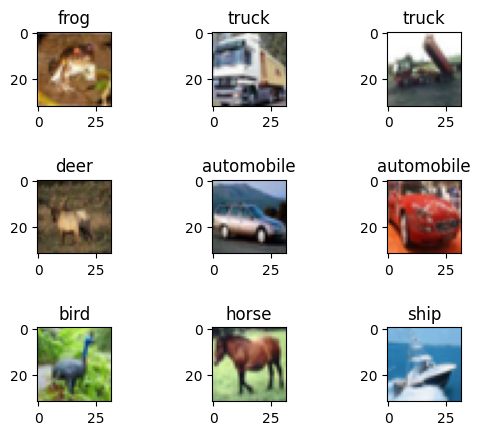

In [6]:
# Pintemos una muestra de las las imagenes del dataset MNIST
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.title(cifar10_labels[y_train[i]])

plt.subplots_adjust(hspace = 1)
plt.show()

Como vamos a querer ir haciendo validación a la vez que entrenamos (muy practico)

In [7]:
x_val = x_train[-10000:]
x_val_scaled = x_train_scaled[-10000:]
y_val = y_train[-10000:]

x_train = x_train[:-10000]
x_train_scaled = x_train_scaled[:-10000]
y_train = y_train[:-10000]

Cuando añadimos convoluciones, necesitamos "pre-tratar los datos", porque **la convolución espera una matriz de 4 campos** (más parecido a "imagenes"), en el caso de MNIST. CIFAR10 ya tiene el shape adecuado, así que no tenemos que hacer nada, pero como siempre decimos: es mejor que comprobeis su tamaño.

Por eso, al salir de la Convolution, hay que hacer un Flatten, porque las capas FullDense esperan arrays, no matrices!!

Luego lo imprimimos para ver que todo está correcto

In [8]:
# Validamos el resultado
print('Train: X=%s, y=%s' % (x_train_scaled.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test_scaled.shape, y_test.shape))
print('Validation: X=%s, y=%s' % (x_val_scaled.shape, y_val.shape))

Train: X=(40000, 32, 32, 3), y=(40000,)
Test: X=(10000, 32, 32, 3), y=(10000,)
Validation: X=(10000, 32, 32, 3), y=(10000,)


## Data augmentation

In [9]:
# Definir el generador de aumento de datos para el conjunto de entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

# Ajustar el generador de aumento de datos a los datos de entrenamiento
train_datagen.fit(x_train)

In [10]:
# Ajustar el generador de aumento de datos a los datos de validación
validation_datagen = ImageDataGenerator(rescale=1./255)

### Ver ejemplos de data augmentation

In [11]:
sample = random.choice(range(0, 40000))

example_generator = train_datagen.flow(
    x_train[sample:sample+1],
    y_train[sample:sample+1],
    batch_size=20
    )

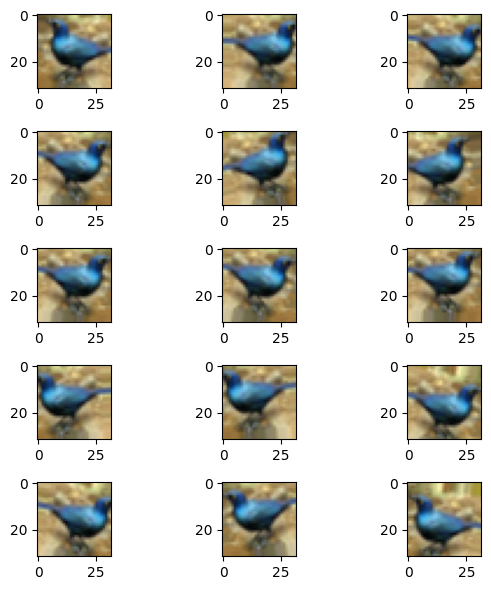

In [12]:
plt.figure(figsize=(6, 6))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X, Y in example_generator:
        image = X[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## 3. Arquitectura de red del modelo

In [13]:
model = ks.Sequential()

# Primera capa convolucional
model.add(Conv2D(32, (3, 3), input_shape=(32,32,3),activation='relu',
                            padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu',
                           padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Segunda capa convolucional
model.add(Conv2D(64, (3, 3), activation='relu',
                           padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu',
                           padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Tercera capa convolucional
model.add(Conv2D(128, (3, 3), activation='relu',
                           padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu',
                           padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Capa de aplanamiento
model.add(Flatten())

# Capa completamente conectada
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Capa de salida
model.add(Dense(10, activation='softmax'))

In [14]:
# Compilación del modelo
model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Para revisar un modelo, nos basta con llamar al método **.summary()** del modelo

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

### Definamos un callback para el Early Stopping

In [16]:
# Definir el callback de EarlyStopping
early_stopping_val_loss = EarlyStopping(monitor = 'val_loss',
                                        patience = 10,
                                        restore_best_weights = True)
early_stopping_val_accuracy = EarlyStopping(monitor = "val_accuracy",
                                            patience = 10,
                                            restore_best_weights = True)

## 5. Entrenamiento del modelo

Ya podemos ponernos a entrenar el modelo!! Ojo, que hemos de entrenar contra los datos convertidos al formato que espera la Convolution.

Empezaremos con 30 epocs, es decir, 30 pasadas completas del dataset (que a su vez sera con mini-batches internamente), fijando un batch de 64

El metodo .fit() nos permite, definir además si disponemos de varias CPUs, GPUs, y si queremos ir validando datos a cada fin de epoch.

In [17]:
# Define the hyperparameters
BATCH_SIZE = 256
EPOCHS = 100

In [18]:
t = time.perf_counter()

In [19]:
# Entrenamiento con Data Augmentation:
history = model.fit(train_datagen.flow(x_train,
                                       y_train,
                                       batch_size = BATCH_SIZE),
                    epochs = EPOCHS,
                    callbacks = [early_stopping_val_loss, early_stopping_val_accuracy],
                    steps_per_epoch = math.ceil(len(x_train)/BATCH_SIZE),
                    validation_data = validation_datagen.flow(x_val,
                                                              y_val,
                                                              batch_size = BATCH_SIZE),
                    validation_steps = math.ceil(len(x_val)/BATCH_SIZE),
                    shuffle=True)

Epoch 1/100
157/157 [==============================] - 33s 149ms/step - loss: 1.7987 - accuracy: 0.3754 - val_loss: 3.1742 - val_accuracy: 0.1616
Epoch 2/100
157/157 [==============================] - 26s 163ms/step - loss: 1.3586 - accuracy: 0.5113 - val_loss: 3.9745 - val_accuracy: 0.1764
Epoch 3/100
157/157 [==============================] - 28s 181ms/step - loss: 1.1673 - accuracy: 0.5835 - val_loss: 1.6823 - val_accuracy: 0.4374
Epoch 4/100
157/157 [==============================] - 24s 151ms/step - loss: 1.0324 - accuracy: 0.6327 - val_loss: 0.9459 - val_accuracy: 0.6667
Epoch 5/100
157/157 [==============================] - 23s 148ms/step - loss: 0.9360 - accuracy: 0.6663 - val_loss: 1.0102 - val_accuracy: 0.6606
Epoch 6/100
157/157 [==============================] - 23s 148ms/step - loss: 0.8731 - accuracy: 0.6933 - val_loss: 0.8134 - val_accuracy: 0.7178
Epoch 7/100
157/157 [==============================] - 24s 152ms/step - loss: 0.8236 - accuracy: 0.7109 - val_loss: 0.8959 -

In [20]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Tiempo de entrenamiento:', elapsed_time)

Tiempo de entrenamiento: 0:20:25.159844


## 6. Evaluamos los resultados

Obtengamos una grafica de como el error y la accuracy van evolucionando en cada epoch en los datos de entrenamiento y en la validación

In [21]:
# Calcular las métricas
acc_train = model.evaluate(x_train_scaled, y_train, verbose=0)[1]
acc_test = model.evaluate(x_test_scaled, y_test, verbose=0)[1]
loss_train = model.evaluate(x_train_scaled, y_train, verbose=0)[0]
loss_test = model.evaluate(x_test_scaled, y_test, verbose=0)[0]

In [22]:
print('Accuracy (train): %.3f' % (acc_train * 100.0))
print('Accuracy (test): %.3f' % (acc_test * 100.0))

Accuracy (train): 92.820
Accuracy (test): 85.940


In [23]:
print('Cross Entropy Loss (train): %.3f' % loss_train)
print('Cross Entropy Loss (test): %.3f' % loss_test)

Cross Entropy Loss (train): 0.206
Cross Entropy Loss (test): 0.426


In [24]:
# Obtener la fecha y hora actual:
now = datetime.datetime.now()

# Crear un DataFrame con los resultados:
data = {'Fecha': [now],
        'Nombre del notebook': ['230631_5_cnn-cifar10.ipynb'],
        'Accuracy (train)': [acc_train],
        'Accuracy (test)': [acc_test],
        'Cross Entropy Loss (train)': [loss_train],
        'Cross Entropy Loss (test)': [loss_test]}

df = pd.DataFrame(data)

# Ubicación del archivo:
ruta_archivo = '/content/drive/MyDrive/NDS_2023/Isi/Entregable/CIFAR10_resultados.xlsx'

# Cargar el archivo existente si existe, de lo contrario, crear uno nuevo:
if os.path.exists(ruta_archivo):
    existing_df = pd.read_excel(ruta_archivo)
else:
    existing_df = pd.DataFrame()

# Agregar el nuevo DataFrame al DataFrame existente:
updated_df = existing_df.append(df)

# Guardar el DataFrame actualizado en el archivo de Excel:
updated_df.to_excel(ruta_archivo, index=False)


<ipython-input-24-87c90871e17d>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = existing_df.append(df)


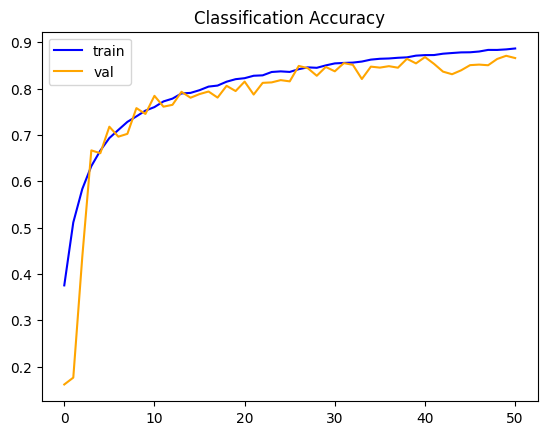

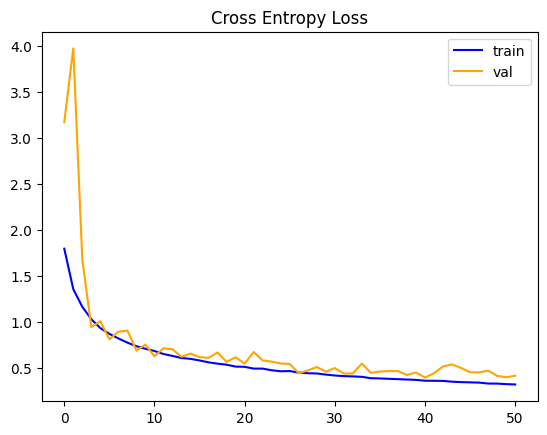

In [25]:
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='val')
plt.legend()
plt.show()

plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='val')
plt.legend()
plt.show()

El coste podemos ver que es estable y es en el epoch 15 que se fija en un valor. Además la accuracy baila alrededor de 0.10. No se puede decir que sea un modelo muy bueno.

Veamos que tipo de predicciones estoy obteniendo sobre el conjunto de test (vamos a pintar las imagenes y sus clasificaciones)

In [26]:
predictions = model.predict(x_test)

313/313 [==============================] - 1s 2ms/step


Una de las ventajas de Python es que hay montones de funciones y código realizado por terceras personas. Aquí me he fusilado unas bonitas funciones (que he adaptado un poco a mis necesidades) para poder pintar las imagenes, su label (ground truth) y las clasificaciones que hemos realizado.

In [27]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Dibujamos las primeras imagenes, con las predicciones y sus valores reales (un total de 20 imagenes, para no abusar de vuestros laptops)

Coloreamos las prediciones correctas en azul y los fallos en rojo. Aunque primero he impreso las etiquetas para que tengamos una referencia al grafico.

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


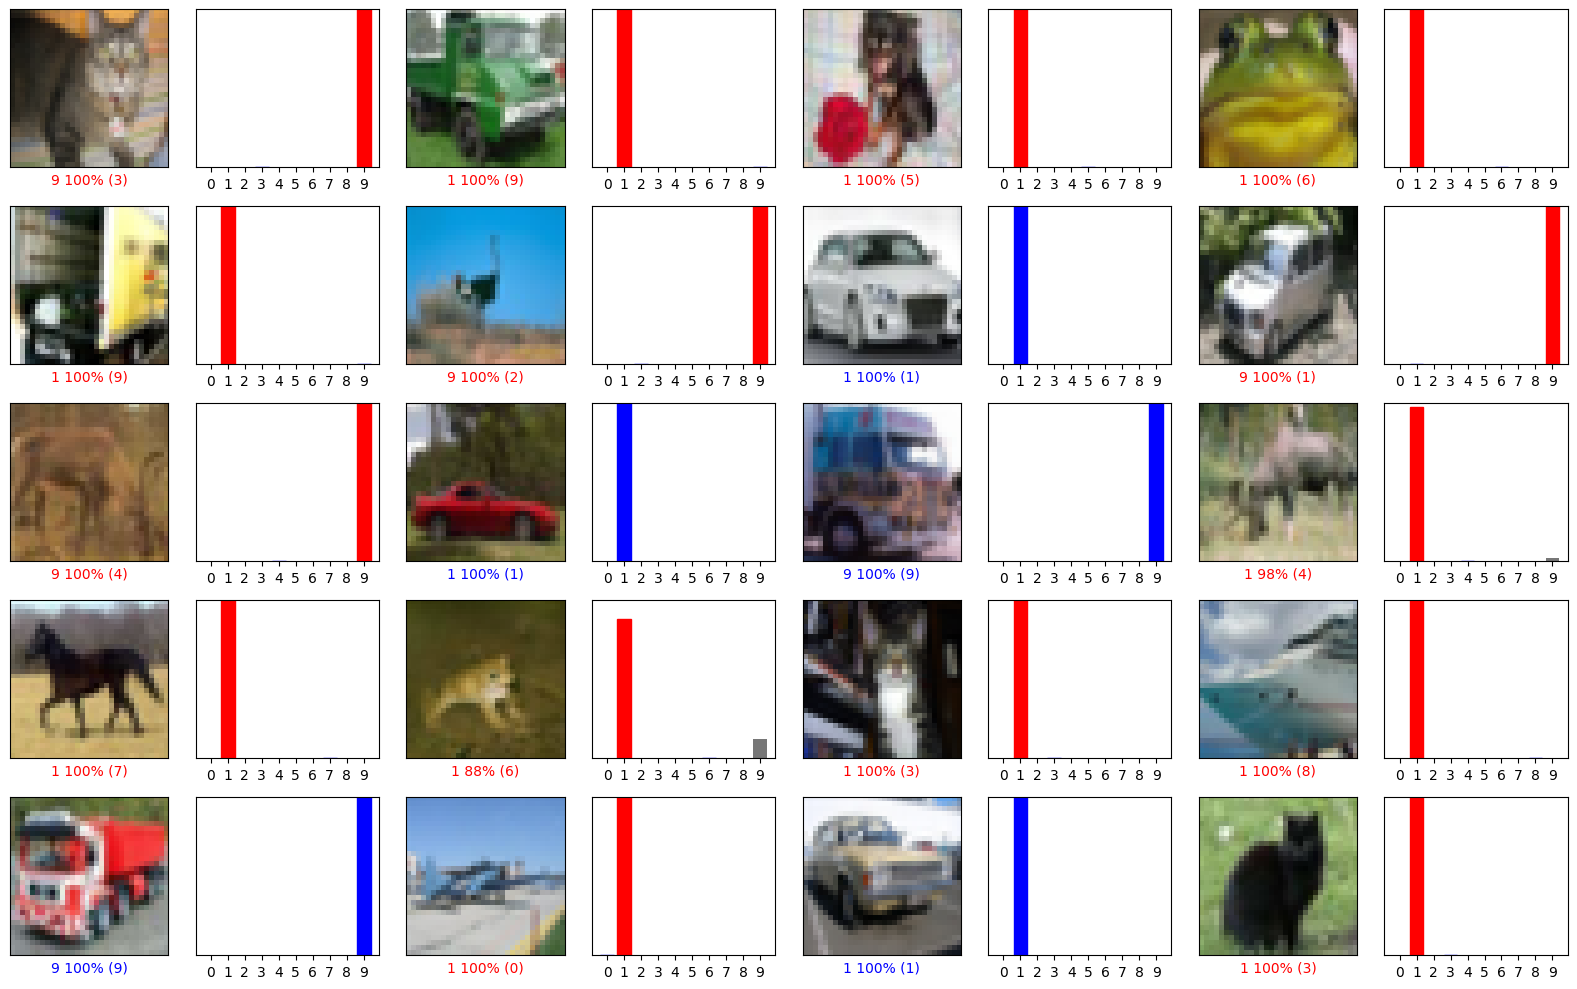

In [28]:
i = 0
for l in cifar10_labels:
    print(i, l)
    i += 1

num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i+start, predictions[i+start], y_test, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()

## 7. Guardamos el modelo para futuras evaluaciones

Id cambiando los nombres del archivo para ir guardando los diversos proyectos.
Aquí lo guardamos en "local", pero recordad que lo ideal es que lo guardeis en Google Drive (teneis que montar la unidad, fijar la ruta y allí guardar el modelo .h5)

In [29]:
ruta_googledrive = "/content/drive/MyDrive/NDS_2023/Isi/Entregable/models/"

# Guardar el modelo
model.save(ruta_googledrive + '230631_5_cnn-cifar10_model.h5')